## Structural and Semantic Clustering
#### This Jupyter notebook is dedicated to different methods for clustering KGs

In [9]:
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from adjustText import adjust_text

### K-means clustering of adjacency matrices (Chapter 5.3.2)

In [10]:
# RUN THIS BOX
def perform_clustering(loaded_adj_matrices):
    def extract_features_from_adj_matrices(adj_matrices):
        flattened_matrices = [adj_matrix.flatten() for adj_matrix in adj_matrices]
        return np.concatenate(flattened_matrices)

    firm_features = []
    firm_names = []

    for firm, adj_matrices in loaded_adj_matrices.items():
        if adj_matrices is not None:
            features = extract_features_from_adj_matrices(adj_matrices)
            firm_features.append(features)
            firm_names.append(firm)

    firm_features = np.array(firm_features)

    # Remove zero-variance features
    selector = VarianceThreshold(threshold=0.0)
    firm_features_reduced = selector.fit_transform(firm_features)

    print(f"Original number of features: {firm_features.shape[1]}")
    print(f"Number of features after removing zero variance: {firm_features_reduced.shape[1]}")

    # Normalise features
    scaler = StandardScaler()
    firm_features_normalized = scaler.fit_transform(firm_features_reduced)

    return firm_names, firm_features_normalized


def make_kmeans_plot(firm_names, firm_features_normalized, n_clusters=2, depth=-1, with_tags='no', exclude_firms=None, box_position='right'):
    if n_clusters < 2:
        raise KeyError("Please choose a K higher than 1")

    #firm_features_normalized = np.load('data/firm_features_normalized.npy')
    #firm_names = np.load('data/firm_names.npy')

    # Exclude specified firms
    if exclude_firms is not None:
        exclude_indices = [i for i, firm in enumerate(firm_names) if firm in exclude_firms]
        firm_features_normalized = np.delete(firm_features_normalized, exclude_indices, axis=0)
        firm_names = np.delete(firm_names, exclude_indices, axis=0)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(firm_features_normalized)
    sil_score = silhouette_score(firm_features_normalized, kmeans_labels)

    # Apply PCA for dimensionality reduction
    pca = IncrementalPCA(n_components=2, batch_size=200)
    reduced_features = pca.fit_transform(firm_features_normalized)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis')

    texts = []
    for i, (firm, cluster) in enumerate(zip(firm_names, kmeans_labels)):
        texts.append(plt.text(reduced_features[i, 0], reduced_features[i, 1], firm, fontsize=10, alpha=0.75))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))

    # Add box info
    prune_text = 'no'
    if depth > 0:
        prune_text = depth
    textstr = f"{with_tags.capitalize()} tags\nPruned: {prune_text}\n\nNum clusters: {n_clusters}\nSil score: {sil_score:.3f}"
    props = dict(boxstyle='square,pad=0.5', facecolor='lightgrey', edgecolor='black', alpha=0.75)
    
    position = (0.85, 0.80)
    if box_position == 'left':
        position = (0.04, 0.80)
    elif box_position == 'down_right':
        position = (0.85, 0.05)
    elif box_position == 'down_left':
        position = (0.04, 0.05)

    plt.text(position[0], position[1], textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='left', bbox=props)

    plt.title(f'K-means Clustering of Adjacency Matrices')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    plt.show()
    plt.close()

Original number of features: 18605000
Number of features after removing zero variance: 3105


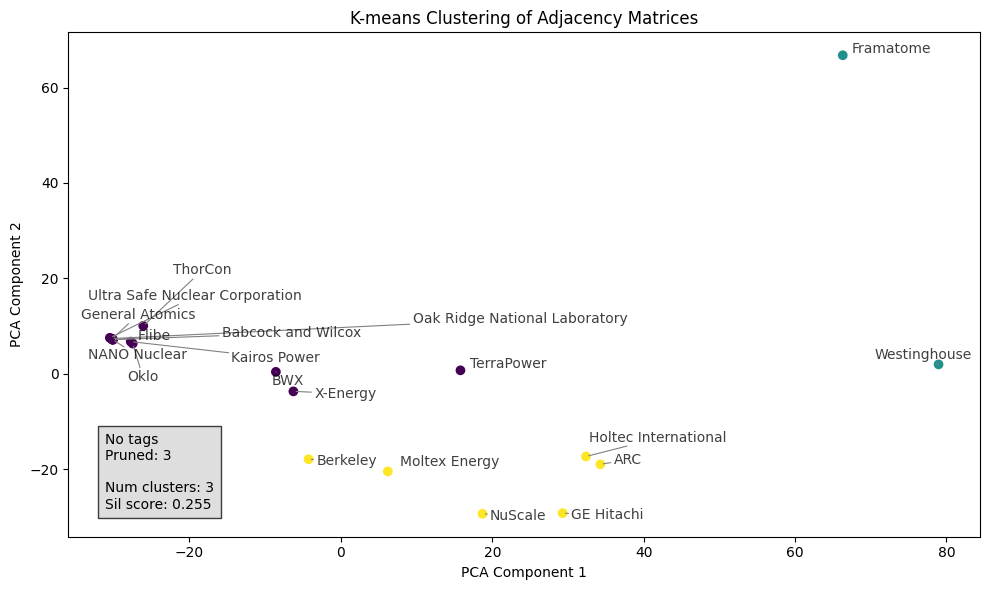

In [11]:
#########
depth = 3  # Options: -1 (unpruned), 1, 2, 3
with_tags = 'no' # Options: 'with' (yes) and 'no' (no)
K = 3
box_position = 'down_left' # Options: 'right' (top right), 'left' (top left), 'down_right' (bottom right), 'down_left' (bottom left)

exclude_firms = None
# Example: exclude_firms = ['Ultra Safe Nuclear Corporation', 'Babcock and Wilcox', 'General Atomics']
#########

filepath = f'../Method:Knowledge_Graphs/data/triplets_no_cutoff/adj_matrices_reduced_rel_dim_pruned_{depth}_{with_tags}_tags.npz'
loaded_data = np.load(filepath, allow_pickle=False)
loaded_adj_matrices = {key: loaded_data[key] for key in loaded_data}
firm_names, firm_features = perform_clustering(loaded_adj_matrices)

make_kmeans_plot(firm_names, firm_features,
                 n_clusters=K, depth=depth, with_tags=with_tags, 
                 exclude_firms=exclude_firms,   # Optional: provide a list of firms to exclude from clsutering
                 box_position=box_position 
                 )          

### GMM clustering of word embeddings (Chapter 5.3.3)

In [4]:
# RUN THIS BOX
def make_GMM_plot_for_nodes(n_clusters, aggregation_method, with_tags='no', exclude_firms=None, box_position='right'):
    # Load data
    with open(f"input/node_embeddings_{with_tags}_tags.json", 'r') as file:
        company_embeddings = json.load(file)
    
    companies = list(company_embeddings[aggregation_method].keys())
    X = np.array(list(company_embeddings[aggregation_method].values()))

    # Remove 'exclude firms' list
    def filter_companies(X, companies, exclude_firms=None):
        if exclude_firms is not None:
            exclude_indices = [i for i, company in enumerate(companies) if company in exclude_firms]
            X = np.delete(X, exclude_indices, axis=0)
            companies = np.delete(companies, exclude_indices, axis=0)
        return X, companies
    
    X, companies = filter_companies(X, companies, exclude_firms)

    # Normalise data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Apply clustering
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X_normalized)

    # PCA for dimensionality reduction 
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_normalized)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=gmm_labels, cmap='viridis', s=50, alpha=0.7)

    sil_score = silhouette_score(X, gmm_labels)

    # Add box info
    textstr = f"Method: {aggregation_method}\n{with_tags.capitalize()} tags\nNum clusters: {n_clusters}\nSil score: {sil_score:.3f}"
    props = dict(boxstyle='square,pad=0.5', facecolor='lightgrey', edgecolor='black', alpha=0.75)

    position = (0.85, 0.95)
    if box_position == 'left':
        position = (0.03, 0.95)
    elif box_position == 'down_right':
        position = (0.85, 0.17)
    elif box_position == 'down_left':
        position = (0.03, 0.17)

    plt.text(position[0], position[1], textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    # Annotate company names
    texts = []
    for i, company_name in enumerate(companies):
        texts.append(plt.text(X_reduced[i, 0], X_reduced[i, 1], company_name, fontsize=9))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.title(f'GMM Clustering on {aggregation_method.capitalize()} of Node Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    plt.show()

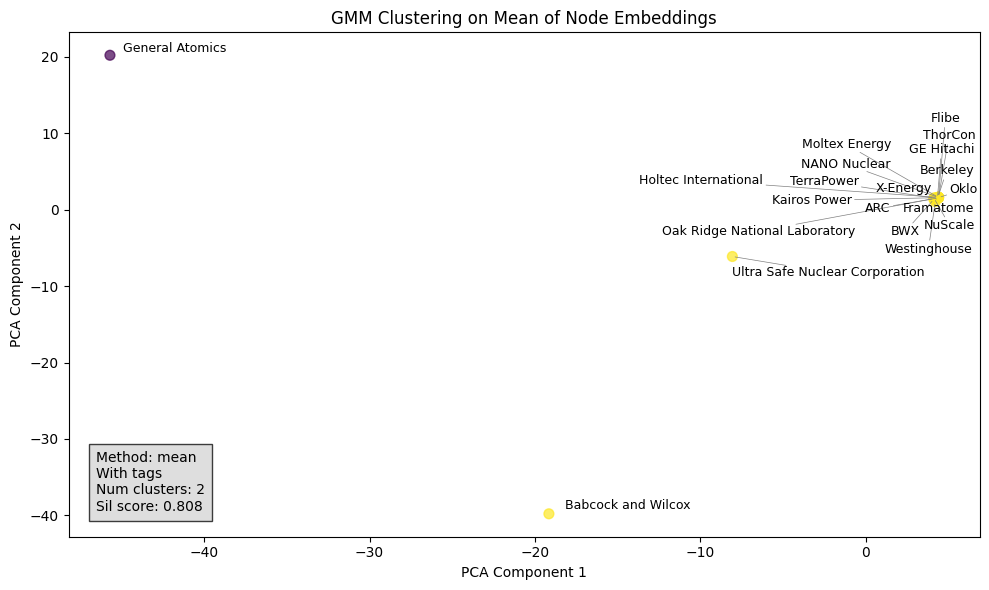

In [5]:
#######
with_tags = 'with' # Options: 'with', 'no'
aggregation_method = 'mean' # Options: 'min', 'max', 'median', 'mean'
K = 2
box_position = 'down_left' # Options: 'right' (top right), 'left' (top left), 'down_right' (bottom right), 'down_left' (bottom left)

exclude_firms = None
# Example: exclude_firms = ['Ultra Safe Nuclear Corporation', 'Babcock and Wilcox', 'General Atomics']
#######

with open(f"input/node_embeddings_{with_tags}_tags.json", 'r') as file:
    company_embeddings = json.load(file)
companies = list(company_embeddings[aggregation_method].keys())
X = np.array(list(company_embeddings[aggregation_method].values()))
make_GMM_plot_for_nodes(K, 
                        aggregation_method, 
                        with_tags, 
                        exclude_firms, 
                        box_position=box_position
                        )

### GMM Clustering on Relation Embeddings (Chapter 5.3.3)

In [8]:
# RUN THIS BOX
def make_GMM_plot_for_relations(n_clusters, aggregation_method, exclude_firms=None, box_position='right'):
    # Load data
    with open(f"input/relation_embeddings.json", 'r') as file:
        company_embeddings = json.load(file)
    
    companies = list(company_embeddings[aggregation_method].keys())
    X = np.array(list(company_embeddings[aggregation_method].values()))

    # Remove 'exclude firms' list
    def filter_companies(X, companies, exclude_firms=None):
        if exclude_firms is not None:
            exclude_indices = [i for i, company in enumerate(companies) if company in exclude_firms]
            X = np.delete(X, exclude_indices, axis=0)
            companies = np.delete(companies, exclude_indices, axis=0)
        return X, companies
    
    X, companies = filter_companies(X, companies, exclude_firms)

    # Normalize data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Apply GMM clustering
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X_normalized)

    # PCA for dimensionality reduction 
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_normalized)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=gmm_labels, cmap='viridis', s=50, alpha=0.7)

    sil_score = silhouette_score(X, gmm_labels)

    # Add box info
    textstr = f"Method: {aggregation_method}\nNum clusters: {n_clusters}\nSil score: {sil_score:.3f}"
    props = dict(boxstyle='square,pad=0.5', facecolor='lightgrey', edgecolor='black', alpha=0.75)

    position = (0.85, 0.95)
    if box_position == 'left':
        position = (0.03, 0.95)
    elif box_position == 'down_right':
        position = (0.85, 0.17)
    elif box_position == 'down_left':
        position = (0.03, 0.17)

    plt.text(position[0], position[1], textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    # Annotate company names
    texts = []
    for i, company_name in enumerate(companies):
        texts.append(plt.text(X_reduced[i, 0], X_reduced[i, 1], company_name, fontsize=9))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.title(f'GMM Clustering on {aggregation_method.capitalize()} of Relation Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    plt.show()

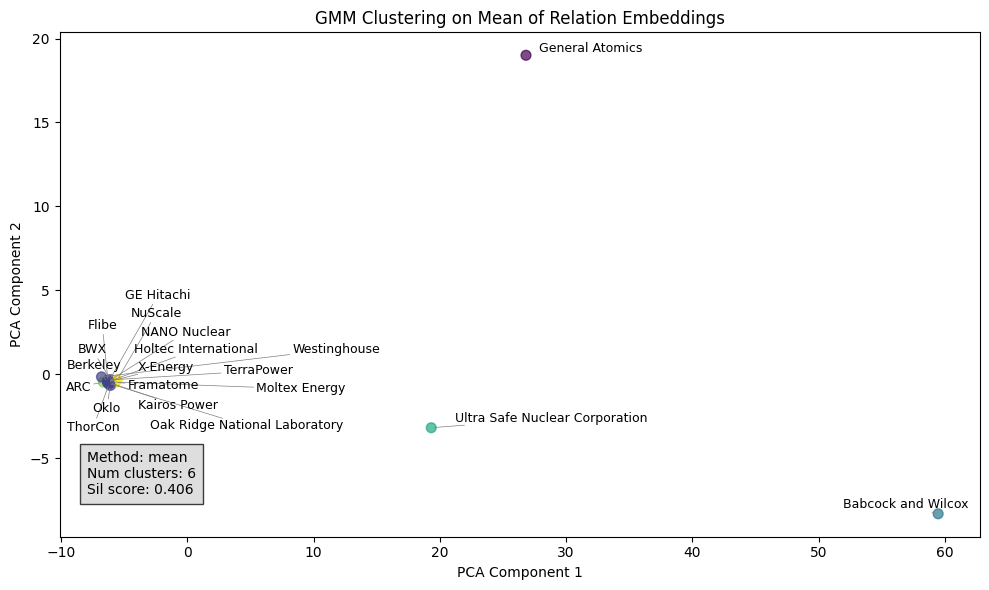

In [7]:
#######
aggregation_method = 'mean' # Options: 'min', 'max', 'median', 'mean'
K = 6
box_position = 'down_left' # Options: 'right' (top right), 'left' (top left), 'down_right' (bottom right), 'down_left' (bottom left)

exclude_firms = None
# Example: exclude_firms = ['Ultra Safe Nuclear Corporation', 'Babcock and Wilcox', 'General Atomics']
#######

# Load data
with open(f"input/relation_embeddings.json", 'r') as file:
    company_embeddings = json.load(file)

companies = list(company_embeddings[aggregation_method].keys())
X = np.array(list(company_embeddings[aggregation_method].values()))
make_GMM_plot_for_relations(K, 
                            aggregation_method, 
                            exclude_firms, 
                            box_position=box_position
                            )